In [1]:
import warnings
# Set warnings to ignore to keep output clean
warnings.filterwarnings('ignore')

In [74]:
# %load_ext autoreload
%autoreload 2

import pandas as pd
import json
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import linregress
import numpy as np
import os

import results_plots
import utils
import my_statistics
import importlib

# Reload the module
importlib.reload(results_plots)
importlib.reload(utils)
importlib.reload(my_statistics)

from results_plots import *
from utils import *
from my_statistics import *


In [3]:
# Obtain the arxiv data
with open("out/text/arxiv/lora_500_clamped_results.json") as f:
  arxiv_500_clamped = json.load(f)
with open("out/text/arxiv/lora_768_clamped_results.json") as f:
  arxiv_768_clamped = json.load(f)
with open("out/text/arxiv/lora_shuffled_results.json") as f:
  arxiv_shuffled = json.load(f)

# Obtain the oxford-pet data
with open("out/vision/oxford-pet/lora_clamped_results.json") as f:
  oxford_clamped = json.load(f)
with open("out/vision/oxford-pet/lora_shuffled_results.json") as f:
  oxford_shuffled = json.load(f)

# Obtain the stanford-dogs data
with open("out/vision/stanford-dogs/lora_clamped_results.json") as f:
  stanford_clamped = json.load(f)
with open("out/vision/stanford-dogs/lora_shuffled_results.json") as f:
  stanford_shuffled = json.load(f)

datasets = {
  "arxiv_500_clamped": arxiv_500_clamped,
  "arxiv_768_clamped": arxiv_768_clamped,
  "arxiv_shuffled": arxiv_shuffled,
  "oxford_clamped": oxford_clamped,
  "oxford_shuffled": oxford_shuffled,
  "stanford_clamped": stanford_clamped,
  "stanford_shuffled": stanford_shuffled
}

In [4]:
def trim_data(dataset, clamp_indices=500, num_layers=12):
    for key in dataset.keys():
        for i in range(num_layers):
            layer = 'layer_' + str(i)
            for attn_matrix in ['key', 'query', 'value']:
                dataset[key]['SVD Diagonal Entries'][layer][attn_matrix] = dataset[key]['SVD Diagonal Entries'][layer][attn_matrix][:clamp_indices]
    return dataset

In [41]:
# Preprocess datasets:
for key in datasets.keys():
    dataset = datasets[key]
    clamp_indices = 500
    if key == "arxiv_768_clamped":
        clamp_indices = 768
    dataset = trim_data(dataset, clamp_indices=clamp_indices)
    datasets[key] = add_intrinsic_dimension_coeffs(dataset)

In [11]:
dataset = datasets["arxiv_500_clamped"]
test_key = list(dataset.keys())[0]
dataset[test_key].keys()

dict_keys(['Metrics', 'SVD Diagonal Entries', 'Coefficients'])

In [48]:
one_run = {}
for run, data in datasets["arxiv_500_clamped"].items():
    num_classes = int(len(run.split('-')))
    if num_classes not in one_run:
        one_run[num_classes] = run
one_run.keys()
runs = list(one_run.values())

query - layer_0: [0.027243589743589744, 0.07712, 0.10702875399361023, 0.15123900879296562, 0.2698083067092652, 0.5646224859874711] [np.float64(0.9804353546435596), np.float64(0.9830973899199161), np.float64(0.9855475266989088), np.float64(0.9850704996515997), np.float64(0.9851060274229385), np.float64(0.9857383521212032)]
key - layer_0: [0.027243589743589744, 0.07712, 0.10702875399361023, 0.15123900879296562, 0.2698083067092652, 0.5646224859874711] [np.float64(0.9806969225623179), np.float64(0.9828684351152625), np.float64(0.9853700515517266), np.float64(0.9852119499727269), np.float64(0.9849392229976366), np.float64(0.9855495798912598)]
value - layer_0: [0.027243589743589744, 0.07712, 0.10702875399361023, 0.15123900879296562, 0.2698083067092652, 0.5646224859874711] [np.float64(0.9829340936179506), np.float64(0.9850455529981409), np.float64(0.9865766546595842), np.float64(0.9862364210800151), np.float64(0.9861266995147453), np.float64(0.9870139635794912)]


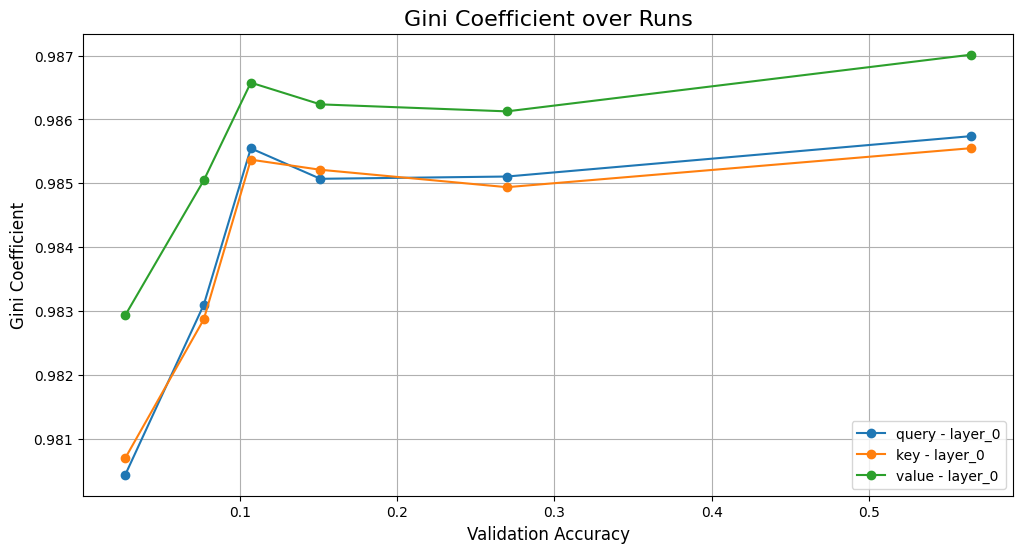

In [76]:
plot_coefficients_over_runs(datasets["arxiv_500_clamped"], "gini", x_axis="best_accuracy", combine_runs=True, layers=['layer_0'], filter_runs=runs)

query - layer_0: [20, 40, 60, 80, 100, 120] [np.float64(0.9804353546435596), np.float64(0.9830973899199161), np.float64(0.9855475266989088), np.float64(0.9850704996515997), np.float64(0.9851060274229385), np.float64(0.9857383521212032)]
key - layer_0: [20, 40, 60, 80, 100, 120] [np.float64(0.9806969225623179), np.float64(0.9828684351152625), np.float64(0.9853700515517266), np.float64(0.9852119499727269), np.float64(0.9849392229976366), np.float64(0.9855495798912598)]
value - layer_0: [20, 40, 60, 80, 100, 120] [np.float64(0.9829340936179506), np.float64(0.9850455529981409), np.float64(0.9865766546595842), np.float64(0.9862364210800151), np.float64(0.9861266995147453), np.float64(0.9870139635794912)]


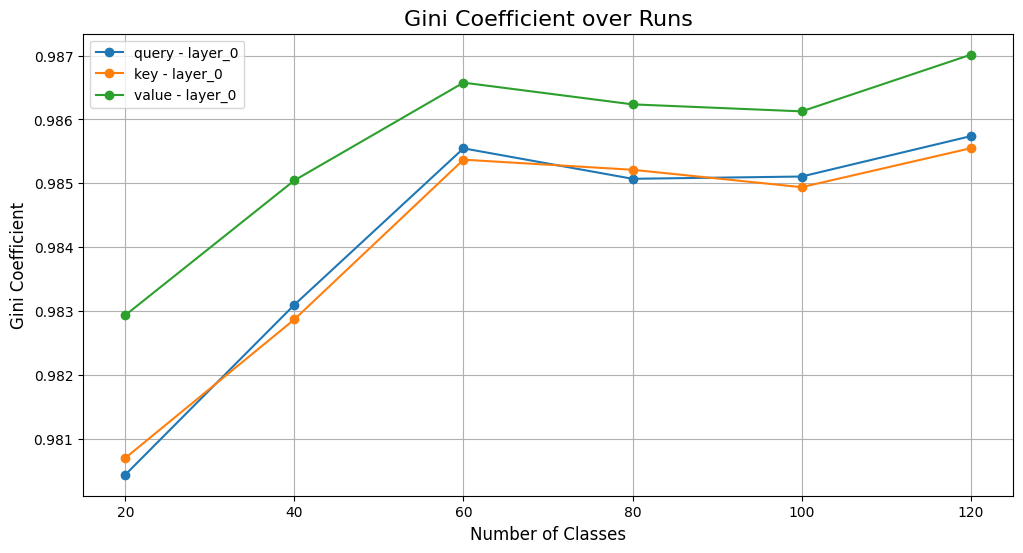

In [71]:
plot_coefficients_over_runs(datasets["arxiv_500_clamped"], "gini", x_axis="num_classes", combine_runs=True, layers=['layer_0'], filter_runs=runs)

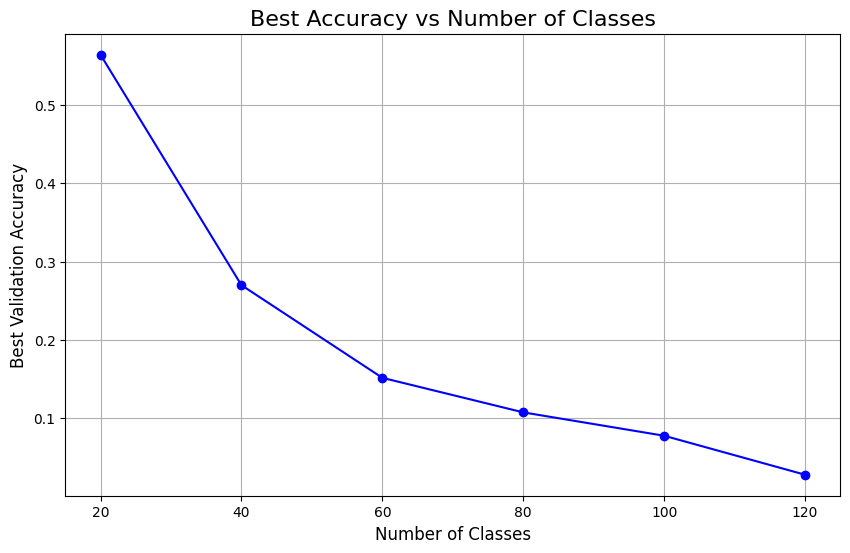

In [75]:
plot_best_accuracy_vs_classes(datasets["arxiv_500_clamped"], filter_runs=runs)

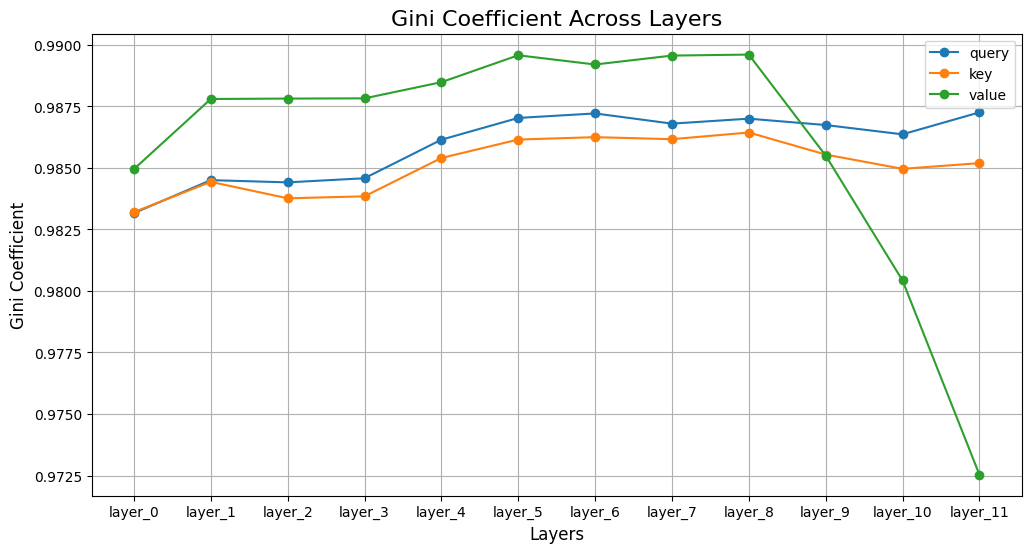

In [32]:
plot_coefficients_across_layers_or_runs(datasets["arxiv_500_clamped"], "gini", mode="layers", combine_runs=True)


In [32]:
# Given the training SVDs, one for each LoRA matrix, calculate all the GINI coefficients, energy and elbow cutoffs
def gather_train_svd_coeffs(train_svds):
    train_svds = train_svds['SVD Diagonal Entries']
    coeffs = {
        "gini": {"query": [], "key": [], "value": []},
        "energy": {"query": [], "key": [], "value": []},
        "elbow": {"query": [], "key": [], "value": []}
    }

    for v in train_svds.values():
        for att_type in ['query', 'key', 'value']:
            coeffs['gini'][att_type].append(gini_coefficient(v[att_type]))
            coeffs['energy'][att_type].append(energy_ratio_test_count(v[att_type], energy_threshold=0.95))
            coeffs['elbow'][att_type].append(elbow_method_count(v[att_type]))

    return coeffs

In [33]:
# Combine coefficients for all keys in lora_clamped_results
combined_coeffs = {
    "gini": {"query": [], "key": [], "value": []},
    "energy": {"query": [], "key": [], "value": []},
    "elbow": {"query": [], "key": [], "value": []}
}

for key in lora_clamped_results:
    stat_data = lora_clamped_results[key]
    coeffs = gather_train_svd_coeffs(stat_data)
    for att_type in ['query', 'key', 'value']:
        for metric in ['gini', 'energy', 'elbow']:
            combined_coeffs[metric][att_type].extend(coeffs[metric][att_type])

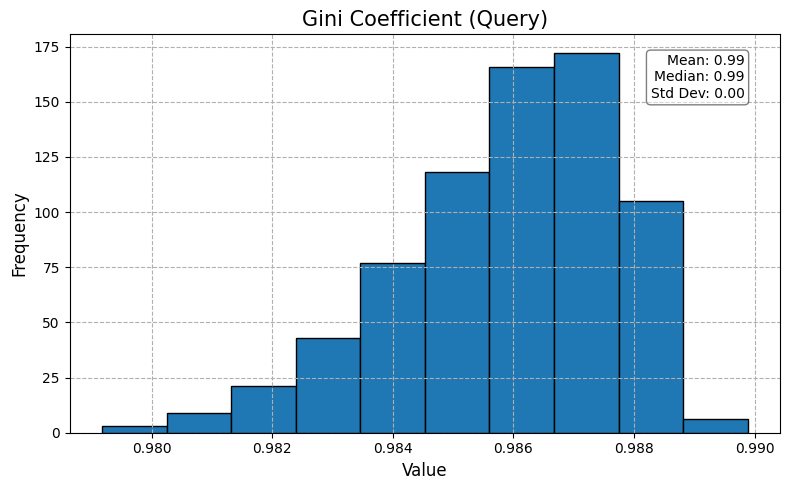

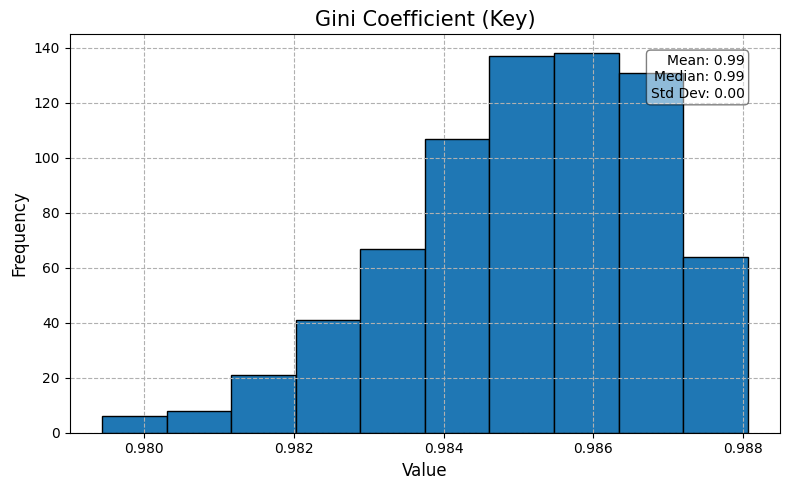

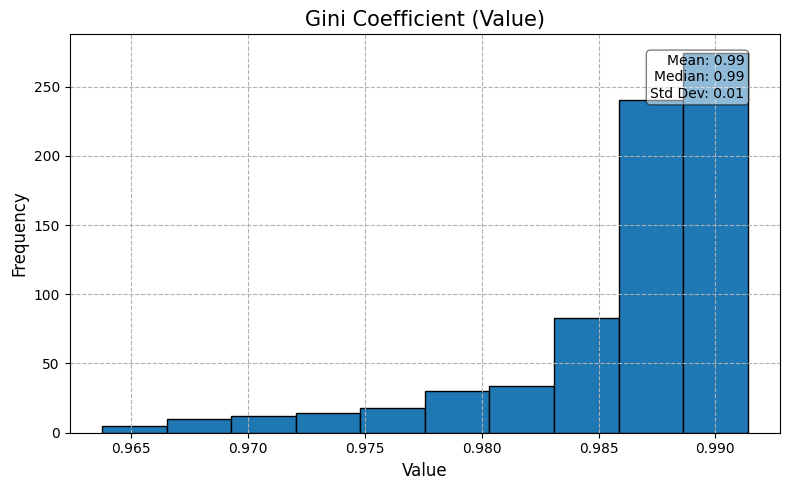

In [34]:
plot_histogram(combined_coeffs['gini']['query'], title="Gini Coefficient (Query)", file_path="results/text/arxiv/hists/gini_query.png")
plot_histogram(combined_coeffs['gini']['key'], title="Gini Coefficient (Key)", file_path="results/text/arxiv/hists/gini_key.png")
plot_histogram(combined_coeffs['gini']['value'], title="Gini Coefficient (Value)", file_path="results/text/arxiv/hists/gini_value.png")

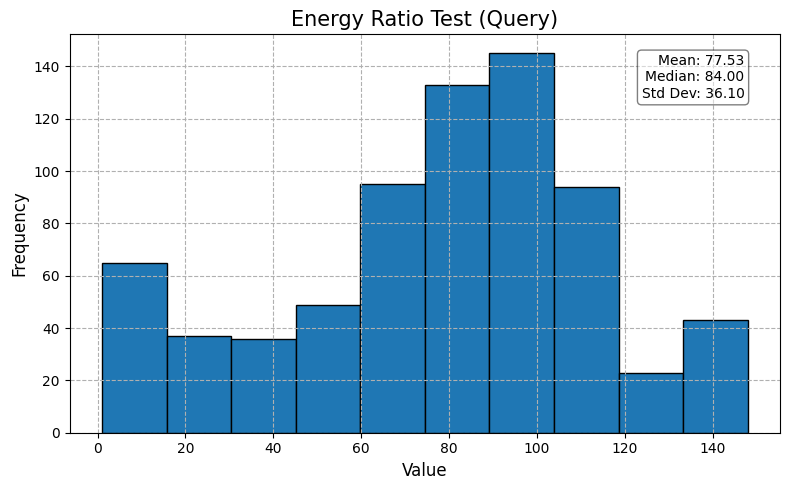

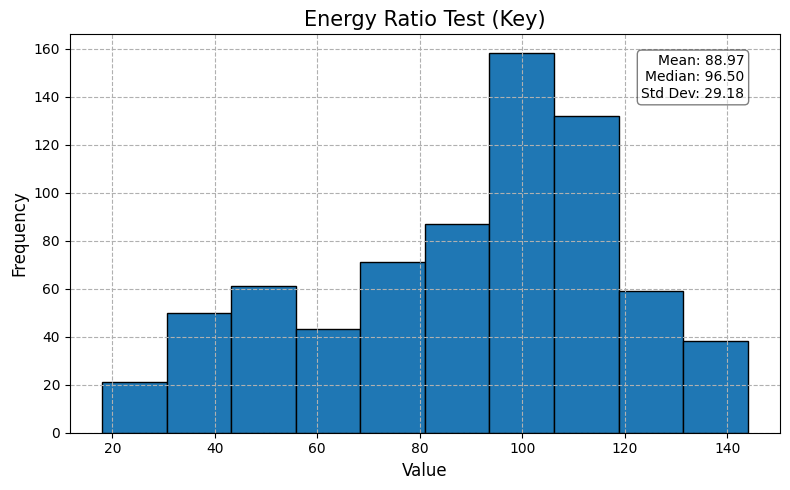

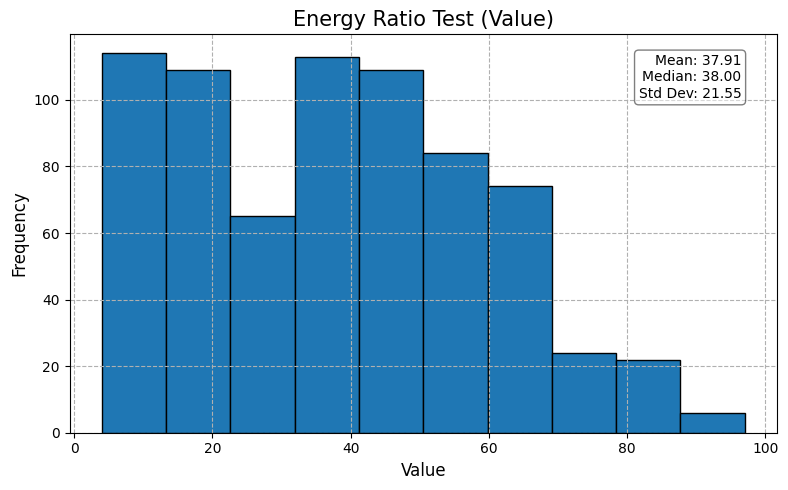

In [35]:
plot_histogram(combined_coeffs['energy']['query'], title="Energy Ratio Test (Query)", file_path="results/text/arxiv/hists/energy_query.png")
plot_histogram(combined_coeffs['energy']['key'], title="Energy Ratio Test (Key)", file_path="results/text/arxiv/hists/energy_key.png")
plot_histogram(combined_coeffs['energy']['value'], title="Energy Ratio Test (Value)", file_path="results/text/arxiv/hists/energy_value.png")

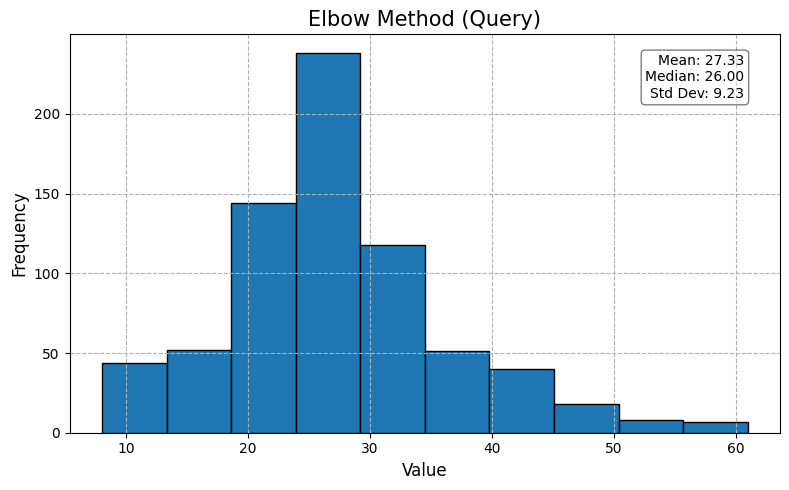

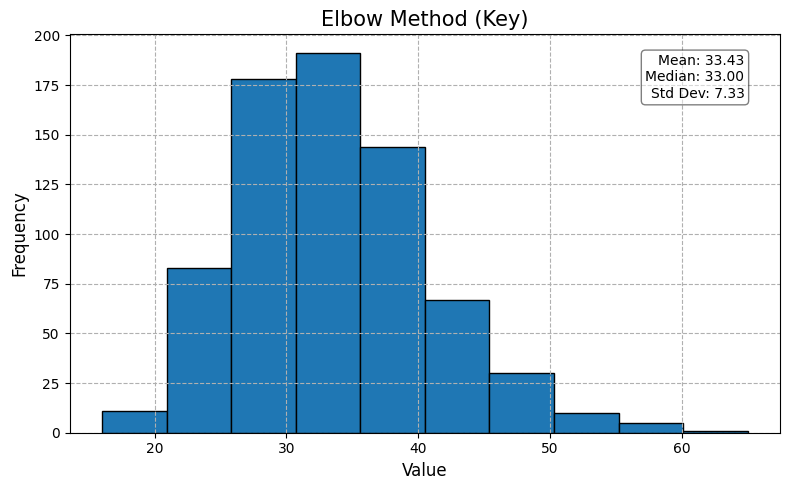

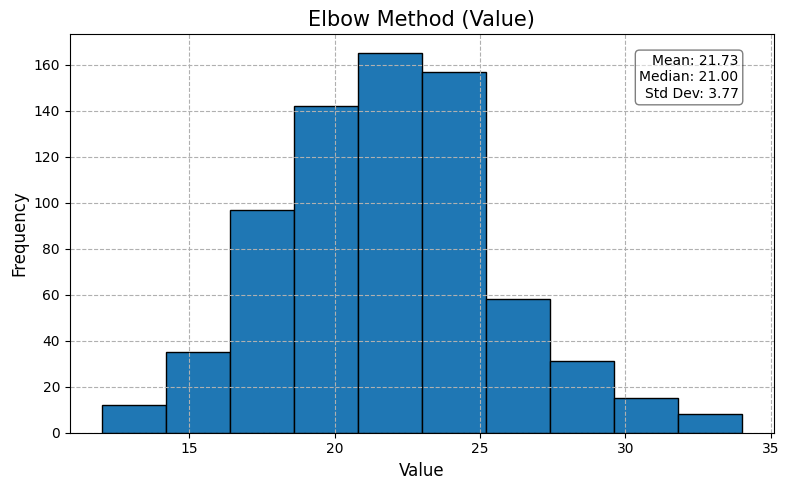

In [36]:
plot_histogram(combined_coeffs['elbow']['query'], title="Elbow Method (Query)", file_path="results/text/arxiv/hists/elbow_query.png")
plot_histogram(combined_coeffs['elbow']['key'], title="Elbow Method (Key)", file_path="results/text/arxiv/hists/elbow_key.png")
plot_histogram(combined_coeffs['elbow']['value'], title="Elbow Method (Value)", file_path="results/text/arxiv/hists/elbow_value.png")

In [37]:
# Given data and the dataset, obtain the aggregated coefficients accross all runs
def gather_coeffs(data, dataset=None, coefficient="gini", aggregate_method="mean"):
    output = {}
    data = data[dataset] if dataset else data
    
    for k, v in data.items():
        num_classes = len(k.split('-'))

        coeffs = gather_train_svd_coeffs(v)
        coeff = coeffs[coefficient]

        if aggregate_method=="mean":
            agg_coeff = np.mean(coeff)
        elif aggregate_method=="median":
            agg_coeff = np.median(coeff)

        if num_classes not in output:
            output[num_classes] = []

        output[num_classes].append(agg_coeff)
  
    return output

In [38]:
# Plotting lora SVD results 
def plot_lora_svd_coefficients(training_data, dataset=None, coefficient="gini", aggregate_method="mean"):
    dataset_coeffs = gather_coeffs(training_data, dataset, coefficient, aggregate_method)
    plt.figure(figsize=(8, 5))

    # Extract x values and corresponding y arrays
    x_values = list(dataset_coeffs)
    y_values = [np.array(dataset_coeffs[x]) for x in x_values]

    # Compute mean and confidence intervals
    means = [np.mean(y) for y in y_values]
    std_devs = [np.std(y, ddof=1) for y in y_values]
    sample_sizes = [len(y) for y in y_values]
    conf_intervals = [1.96 * (std / np.sqrt(n)) for std, n in zip(std_devs, sample_sizes)]

    # Sort data by x-values
    sorted_data = sorted(zip(x_values, means, conf_intervals), key=lambda x: x[0])
    x_sorted, means_sorted, conf_intervals_sorted = zip(*sorted_data)

    # Plot the means and confidence intervals using error bars
    plt.errorbar(
        x_sorted, 
        means_sorted, 
        yerr=conf_intervals_sorted, 
        fmt="--o", 
        ecolor='royalblue', 
        elinewidth=2, 
        capsize=5, 
        label='Mean ± 95% CI'
    )

    # Add labels, legend, and grid
    if coefficient=="gini":
        y_label = "GINI Coefficient"
    elif coefficient=="energy":
        y_label = "Energy-Ratio Test Cutoff"
    elif coefficient=="elbow":
        y_label = "Elbow Method Cutoff"

    plt.xlabel('Number of Classes')
    plt.ylabel(y_label)
    plt.title(f"{y_label} Across Different Class Counts with 95% Confidence Intervals")
    plt.legend()
    plt.grid(True)
    return plt.show()

In [39]:
print("For the Arxiv dataset:")
plot_lora_svd_coefficients(lora_clamped_results, coefficient="gini", aggregate_method='median')
plot_lora_svd_coefficients(lora_clamped_results, coefficient="energy", aggregate_method='median')
plot_lora_svd_coefficients(lora_clamped_results, coefficient="elbow", aggregate_method='median')

For the Arxiv dataset:


TypeError: unsupported operand type(s) for /: 'dict' and 'int'

In [9]:
test_key = '0-6-7-10-16-18-61-68-69-70-75-81-83-87-97-106-109-120-126-127'
svd_results = lora_clamped_results[test_key]['SVD Diagonal Entries']

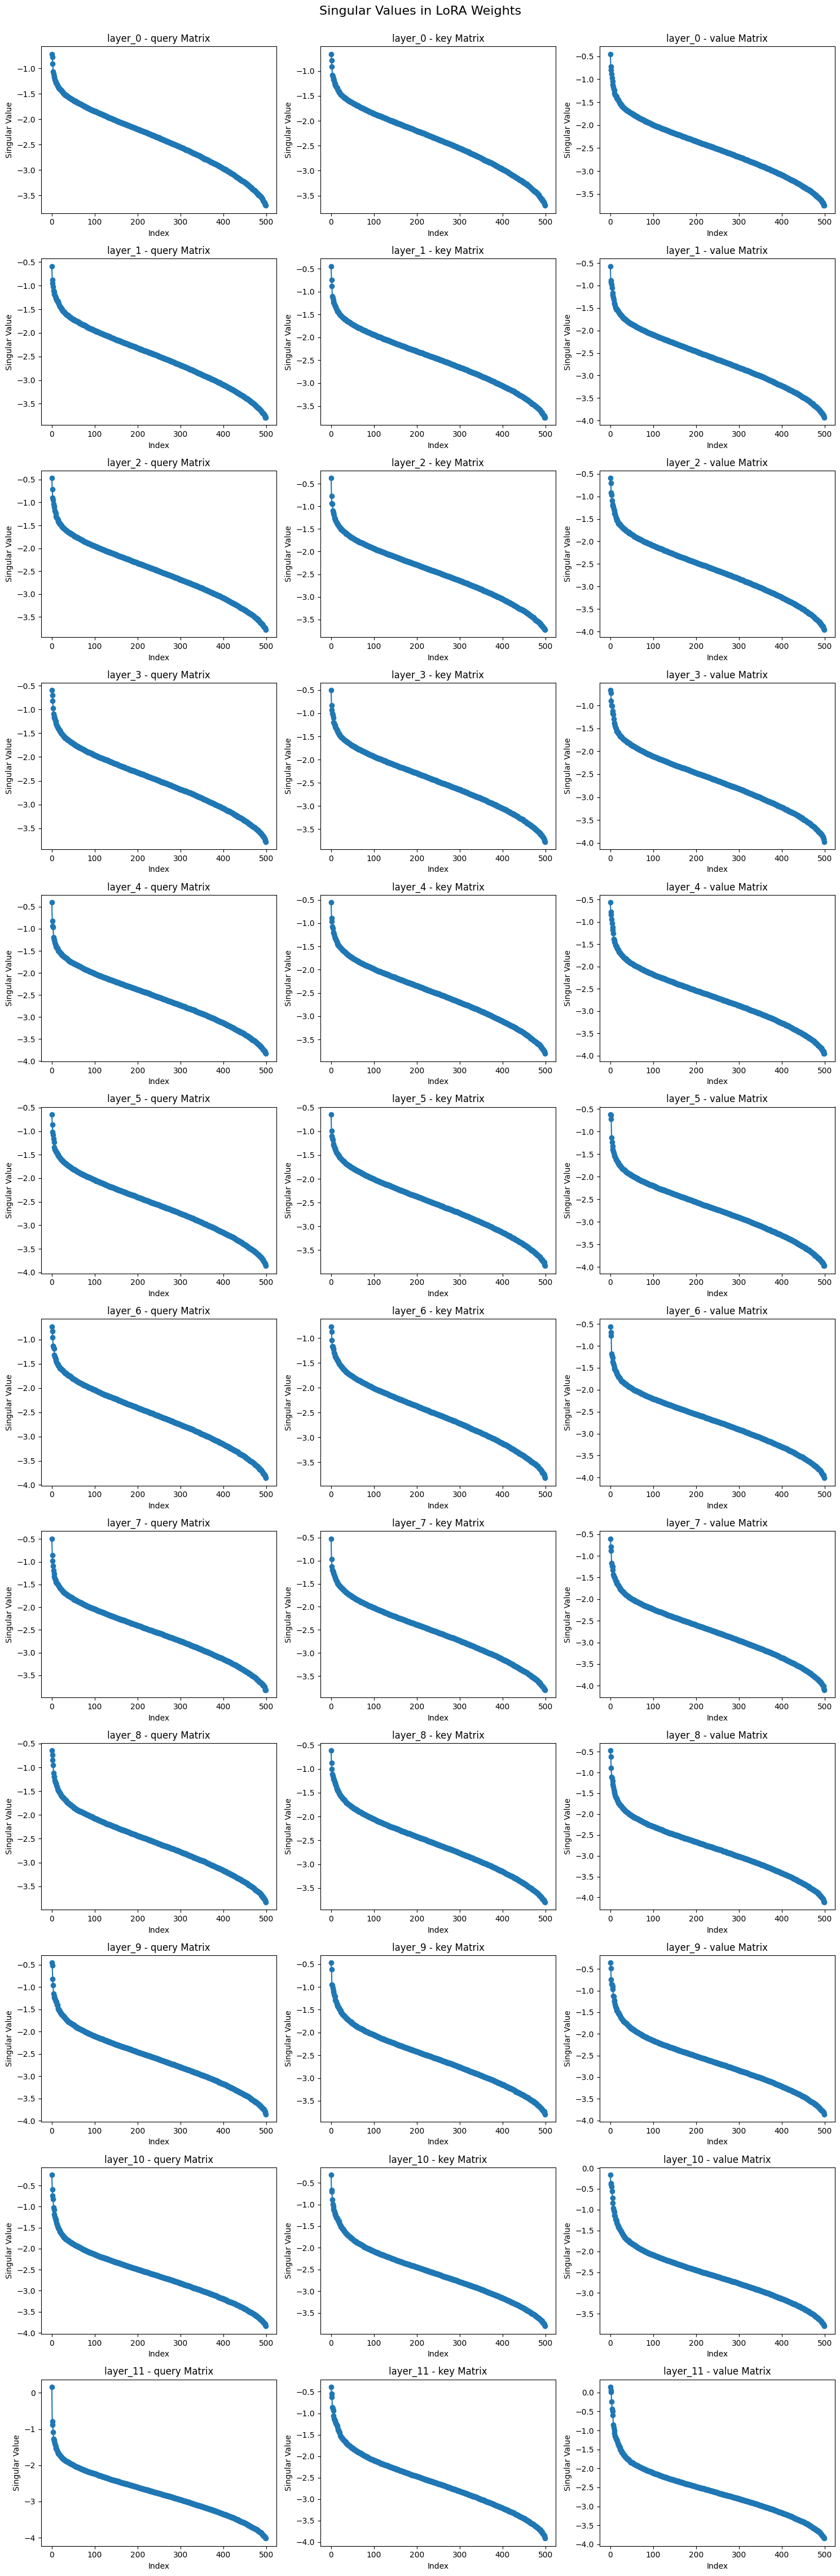

In [10]:
plot_log_lora_svd_singular_values(svd_results)

In [21]:
def test_log_relationship(singular_values, layer_name, matrix_name):
    """
    Test if there is a logarithmic relationship between the index and singular values.
    Plots the original and log-transformed relationships and computes a linear fit.
    """
    indices = np.arange(1, len(singular_values) + 1)  # Avoid log(0) by starting from 1
    log_values = np.log(singular_values)
    
    # Fit a linear model in log space
    slope, intercept, r_value, p_value, std_err = linregress(indices, log_values)
    
    # Plot the original data
    # plt.figure(figsize=(12, 6))
    
    # # Original plot
    # plt.subplot(1, 2, 1)
    # plt.plot(indices, singular_values, marker='o', label='Original')
    # plt.title(f'Original Singular Values ({layer_name} - {matrix_name})')
    # plt.xlabel('Index')
    # plt.ylabel('Singular Value')
    # plt.grid(True)
    # plt.legend()
    
    # # Log-transformed plot
    # plt.subplot(1, 2, 2)
    # plt.plot(indices, log_values, marker='o', label='Log-Transformed')
    # plt.plot(indices, intercept + slope * indices, label=f'Fit (r={r_value:.4f})', linestyle='--')
    # plt.title(f'Log Relationship ({layer_name} - {matrix_name})')
    # plt.xlabel('Index')
    # plt.ylabel('Log(Singular Value)')
    # plt.grid(True)
    # plt.legend()
    
    # plt.tight_layout()
    # plt.show()
    
    print(f"Log Fit: Slope = {(slope * 1000):.4f}, Intercept = {intercept:.2f}, R-squared = {r_value**2:.4f}")
    return (r_value**2, slope, intercept)  # Coefficient of determination (goodness of fit)


In [22]:
r_values, slopes, intercepts = [], [], []

for layer_name, layer_data in svd_results.items():
    for matrix_name, singular_values in layer_data.items():
        print(f"Testing for Logarithmic Relationship: {layer_name} - {matrix_name}")
        r_value, slope, intercept = test_log_relationship(singular_values, layer_name, matrix_name)
        r_values.append(r_value)
        slopes.append(slope)
        intercepts.append(intercept)
        
        # print(f"Testing for Power-Law Relationship: {layer_name} - {matrix_name}")
        # test_power_relationship(singular_values, layer_name, matrix_name)

Testing for Logarithmic Relationship: layer_0 - query
Log Fit: Slope = -9.5757, Intercept = -3.11, R-squared = 0.9830
Testing for Logarithmic Relationship: layer_0 - key
Log Fit: Slope = -9.4853, Intercept = -3.14, R-squared = 0.9817
Testing for Logarithmic Relationship: layer_0 - value
Log Fit: Slope = -9.5189, Intercept = -3.41, R-squared = 0.9708
Testing for Logarithmic Relationship: layer_1 - query
Log Fit: Slope = -9.8441, Intercept = -3.31, R-squared = 0.9805
Testing for Logarithmic Relationship: layer_1 - key
Log Fit: Slope = -9.5392, Intercept = -3.34, R-squared = 0.9781
Testing for Logarithmic Relationship: layer_1 - value
Log Fit: Slope = -9.7861, Intercept = -3.63, R-squared = 0.9737
Testing for Logarithmic Relationship: layer_2 - query
Log Fit: Slope = -9.7470, Intercept = -3.32, R-squared = 0.9766
Testing for Logarithmic Relationship: layer_2 - key
Log Fit: Slope = -9.6327, Intercept = -3.29, R-squared = 0.9769
Testing for Logarithmic Relationship: layer_2 - value
Log Fit:

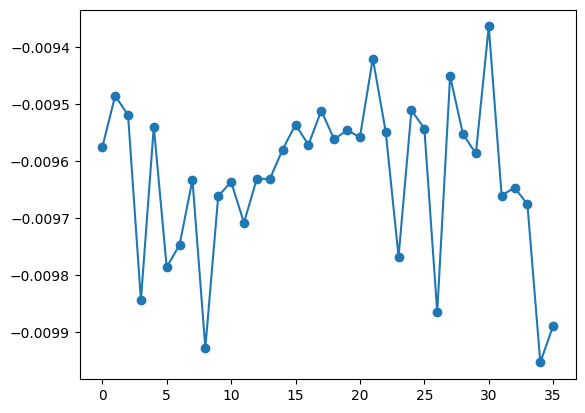

In [26]:
plt.plot(np.array(slopes), marker='o')

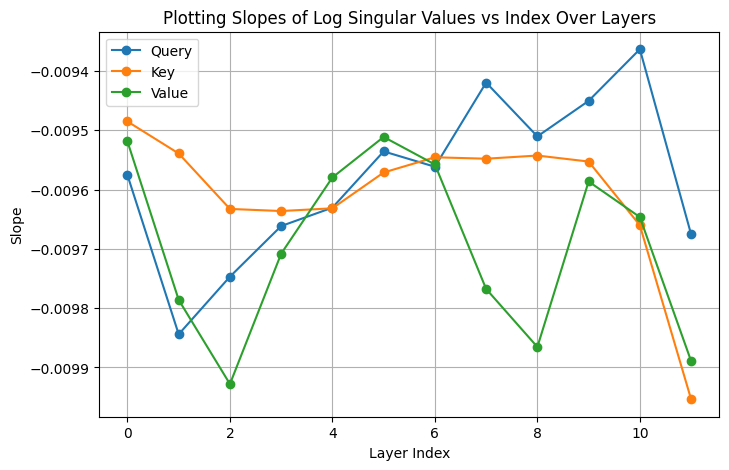

In [27]:
def plot_slopes(arr, title='Plotting Slopes of Log Singular Values vs Index Over Layers'):
    query, key, val = 0, 1, 2
    query_slopes, key_slopes, val_slopes = [], [], []
    for i in range(12):
        query_slopes.append(arr[query])
        key_slopes.append(arr[key])
        val_slopes.append(arr[val])
        query += 3
        key += 3
        val += 3
    plt.figure(figsize=(8, 5))
    plt.plot(query_slopes, marker='o', label='Query')
    plt.plot(key_slopes, marker='o', label='Key')
    plt.plot(val_slopes, marker='o', label='Value')
    plt.title(title)
    plt.xlabel('Layer Index')
    plt.ylabel('Slope')
    plt.grid(True)
    plt.legend()
    return plt.show()

plot_slopes(slopes)

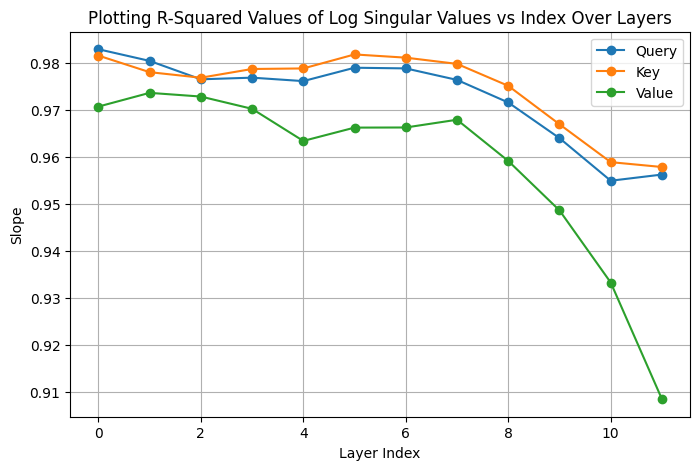

In [28]:
plot_slopes(r_values, title='Plotting R-Squared Values of Log Singular Values vs Index Over Layers')